## Agent Training ##

It's now time to train an agent to (hopefully) learn how to trade stock! For the interested reader, you can read about the problem formulation as a Partially Observable Markov Decision Process (POMDP) in the project proposal document. This final project is slightly different than the original proposal in a few ways, primarily:
1. Temporal Convolutional Networks were used instead of Recurrent Neural Networks.
2. A more recent deterministic actor-critic agent, TD3, was used instead of DDPG.

Let's get started!

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import time

%matplotlib inline

We'll import some functions and classes we defined in the marketenv and simplerl packages, which were developed for this project. These will be described more as we go through the notebook.

In [2]:
from marketenv import (make_env,
                       MarketMonitor, 
                       TradeActionWrapper,
                       ObsStackWrapper,
                       WarmResetWrapper,
                       PortfolioWeightWrapper,
                       SimNormalization)

In [3]:
from simplerl import (DDPGAgent, 
                      DDPGTemporalConvNet,
                      TD3Agent,
                      TD3TemporalConvNet,
                      RandomAgent,
                      OrnsteinUhlenbeckProcess as OUProcess,
                      GaussianProcess,
                      ExponentialScheduler,
                      LinearScheduler,
                      ConstantScheduler,
                      train, 
                      evaluate, 
                      train_and_evaluate, 
                      MarketMonitorHook, 
                      SaverHook,
                      GradientMonitorHook)

To start, let's see how a random agent does in the market environment we developed. You can read more about the environment in the Market Environment notebook.

In [21]:
env = make_env('Market-v3', episode_len = 250)
env = TradeActionWrapper(env, action_scale = 500.0)

random_agent = RandomAgent(env.action_space)
benchmark_monitor = MarketMonitorHook(eval_window = 1000, verbose = 100, vector_env = False)

In [22]:
t = time.time()
evaluate(random_agent, env, hooks = [benchmark_monitor], eval_steps = 250 * 1000, vector_env = False)
print('\nWall time:', (time.time() - t) / 60.0)

Episode 100 | Market Return: -0.48 | Agent Return: -6.68 | Win Rate: 32.00 | Average Spread -3.44
Episode 200 | Market Return: 3.63 | Agent Return: -2.08 | Win Rate: 32.00 | Average Spread -2.90
Episode 300 | Market Return: 15.85 | Agent Return: 16.87 | Win Rate: 32.00 | Average Spread -3.77
Episode 400 | Market Return: 12.84 | Agent Return: 5.14 | Win Rate: 32.00 | Average Spread -3.53
Episode 500 | Market Return: 5.80 | Agent Return: -7.45 | Win Rate: 31.00 | Average Spread -3.89
Episode 600 | Market Return: 27.58 | Agent Return: 28.22 | Win Rate: 32.33 | Average Spread -3.42
Episode 700 | Market Return: 44.08 | Agent Return: 32.28 | Win Rate: 33.00 | Average Spread -3.30
Episode 800 | Market Return: 8.69 | Agent Return: 17.12 | Win Rate: 32.75 | Average Spread -3.37
Episode 900 | Market Return: 16.96 | Agent Return: 7.96 | Win Rate: 32.78 | Average Spread -3.28
Episode 1000 | Market Return: 13.18 | Agent Return: 6.70 | Win Rate: 32.60 | Average Spread -3.43

Wall time: 0.40700505971

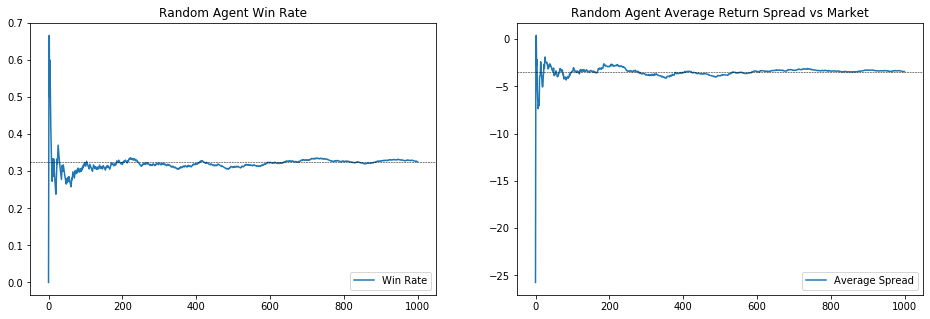

In [23]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

win_rate = pd.Series(benchmark_monitor.agent_wins).rolling(1000, min_periods = 1).mean()

ax[0].title.set_text('Random Agent Win Rate')
ax[0].plot(win_rate.to_numpy(), label = 'Win Rate')
ax[0].axhline(win_rate.iat[-1], color = 'k', linewidth = 0.5, linestyle = '--')
ax[0].legend(loc = 'lower right')

difference = np.asarray(benchmark_monitor.agent_returns) - np.asarray(benchmark_monitor.market_returns)
average_spread = pd.Series(difference).rolling(1000, min_periods = 1).mean()

ax[1].title.set_text('Random Agent Average Return Spread vs Market')
ax[1].plot(average_spread.to_numpy(), label = 'Average Spread')
ax[1].axhline(average_spread.iat[-1], color = 'k', linewidth = 0.5, linestyle = '--')
ax[1].legend(loc = 'lower right')

plt.show()

We'll use the random agent as our benchmark for this project. Hopefully, the agent we train next will do a little better.

The agent we'll be training is a TD3 agent, which you can read about in detail here: https://arxiv.org/pdf/1802.09477. The agent outputs an action, $a \in [-1.0, 1.0]$. This raw action is mapped to $A \in [-100, 100]$ where actions are clipped so that an agent cannot buy more shares than it has cash available nor sell more shares than shares that it currently owns. This is handled by the TradeActionWrapper. 

Because the raw observations, $o \in \mathbb{R}^{16}$ are unscaled and only have information about the environment at a point in time, we'll use a few more wrappers for feature engineering:
1. The PortfolioWeightWrapper scales the agent's cash balance and number of shares held to portfolio weights so that each number is a percentage of the total portfolio value. This brings the scale down to between 0.0 and 1.0, which is very helpful for training.
2. The SimNormalization wrapper normalizes all time series data (the stock price and non-tradable time series data) so that the series have mean 0.0 and variance 1.0: $\hat{o}_{3:16} = (o_{3:16} - \mu) / \sigma$. This is kind of cheating since in real life the mean and variance of the series are unobservable; however, this goes a long way to speeding up learning, which is helpful when training large networks on AWS E2C GPU instances (which aren't cheap!). Earlier tests used a learned scaler that was part of the agent, but it took many time steps until the means and variances stabilized.
3. The ObsStackWrapper stacks previous observations into a single observation, so the agent has access to a time series rather than a single, point in time observation.

Let's take a closer look:

In [4]:
seq_len = 150
episode_len = 250

def env_fn():
    env = make_env('Market-v3', episode_len = episode_len + seq_len)
    env = MarketMonitor(env)
    env = TradeActionWrapper(env, action_scale = 100.0)
    env = PortfolioWeightWrapper(env)
    env = SimNormalization(env)
    env = ObsStackWrapper(env, seq_len)
    env = WarmResetWrapper(env, seq_len)
    
    return env

In [27]:
env = env_fn()
obs = env.reset()
print('Observation Shape:', obs.shape)
print('Latest Step:\n', obs[-1, :])

Observation Shape: (150, 16)
Latest Step:
 [ 1.          0.         -0.46740302  1.61606353  0.24097569 -0.20256904
 -0.47322518 -0.64706739 -0.82450513 -0.51584733 -0.04093215  0.86494642
  0.13164368 -0.27564215 -0.41463491 -0.5229274 ]


The TD3 agent has 3 neural networks: two critic networks that learn to predict the state-action value, $Q_{sa}$, and a policy network that learns to predict a deterministic action, $a \in [-1.0, 1.0]$. The critics are used by the policy network to update the policy using the deterministic policy gradient (see the TD3 paper for additional detail):

$\triangledown J_{\phi}(\phi) = N^{-1}\sum_{}\triangledown_{a} Q_{\theta} (o, a) |_{a=\pi_{\phi}(o)} \triangledown_{\phi} \pi_{\phi} (o)$

Because an observation for a single time step does not contain enough information to make trade decisions, the networks will use temporal convolutional networks (TCNs) so that an agent can learn from a time series of observations. While recurrent neural networks (RNNs) have traditionally been used for time series data, such as in natural language processing tasks, TCNs offer several advantages over RNNs, including better parallelization using GPUs. A great comparison of TCNs versus RNNs was done here: https://arxiv.org/pdf/1803.01271. The author's TCN implementation in Pytorch can be found here, https://github.com/locuslab/TCN/blob/master/TCN/tcn.py, and this was the same implementation used for this project.

TCNs have a fixed receptive field size (i.e., how far back they can look). We used the below formula, which works for the TCN implementation here, to determine the kernel size and number of layers we'll use in the network architecture.

In [29]:
kernel_size = 6
n_layers = 4
field_size = 1 + 2 * (kernel_size - 1) * (2 ** n_layers - 1)
print('Receptive Field Size:', field_size)

Receptive Field Size: 151


Using a TCN with 4 layers and kernel size of 6 gives us a receptive field size of 151, so our agent can see the last 151 observations, which are provided from the ObsStackWrapper. The rest of the selected hyperparameters are below. These were hand tuned based on training the agent for about 100 episodes. We only trained the agent for 100 episodes as training is relatively slow, even with a GPU, for large convolutional neural networks (CNNs). Longer or more advanced hyperparameter tuning could go a long way towards improving performance.

In [5]:
model_fn = lambda: TD3TemporalConvNet(16, 1, (32, 32, 32, 32), (128, 64),
                                      tcn_kernel_size = 6,
                                      action_scale = 1.0,
                                      tcn_dropout = 0.2,
                                      hidden_dropout = 0.2,
                                      feature_scaler = False)

noise_fn = lambda: OUProcess((1, ), ConstantScheduler(0.2))

optimizer = lambda params, lr, weight_decay : optim.Adam(params, lr = lr, weight_decay = weight_decay, eps = 1e-3)

In [6]:
agent = TD3Agent(env_fn = env_fn, 
                 model_fn = model_fn,
                 n_actors = 32,
                 action_range = 1.0,
                 gamma = 0.99,
                 exploration_noise = noise_fn,
                 regularization_noise = GaussianProcess((128, 1), ConstantScheduler(0.2)),
                 noise_clip = (-0.5, 0.5),
                 batch_size = 128,
                 n_steps = 3,
                 replay_memory = 25000,
                 use_per = False,
                 alpha = 0.6,
                 beta = LinearScheduler(0.4, 1.0, 12000),
                 replay_start = 2000,
                 parameter_tau = 1e-3,
                 buffer_tau = 1.0,
                 optimizer = optimizer,
                 policy_learning_rate = 1e-5 * 5,
                 critic_learning_rate = 1e-4 * 5,
                 weight_decay = 1e-4,
                 clip_gradients = 1.0,
                 update_freq = 5, 
                 policy_update_freq = 15)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent.to(device)

The training and evaluation functions defined can be customized using hooks, which are executed at various points during training. Three hooks were used during training:
1. A hook to monitor training and print the current episode and status.
2. A hook to save the model parameters every so often.
3. A hook to monitor the gradients of the network during training, which was primarily used for debugging and hyperparameter tuning.

In [22]:
train_monitor = MarketMonitorHook(eval_window = 100, verbose = 20, vector_env = True)
eval_monitor = MarketMonitorHook(eval_window = 100, verbose = 100, vector_env = True)
saver = SaverHook('./saved_agents', save_every = episode_len * 40)
gradient_monitor = GradientMonitorHook()

Now, we can finally train the agent!

In [23]:
agent.train()
train_and_evaluate(agent, env = None, 
                   train_steps = episode_len * 1400,
                   eval_steps = episode_len * 100,
                   eval_every = episode_len * 80,
                   train_hooks = [train_monitor, saver, gradient_monitor],
                   eval_hooks = [eval_monitor],
                   vector_env = True)

Beginning training
Episode 20 | Market Return: 38.39 | Agent Return: 8.51 | Win Rate: 20.00 | Average Spread -14.31
Model saved to ./saved_agents/model_10000
Episode 40 | Market Return: -6.66 | Agent Return: 4.86 | Win Rate: 40.00 | Average Spread -6.14
Episode 60 | Market Return: 51.49 | Agent Return: 9.17 | Win Rate: 26.67 | Average Spread -11.60
Model saved to ./saved_agents/model_20000
Episode 80 | Market Return: 42.60 | Agent Return: 5.36 | Win Rate: 35.00 | Average Spread -9.65
Beginning evaluation
Episode 100 | Market Return: 21.28 | Agent Return: 0.00 | Win Rate: 33.00 | Average Spread -10.00
Beginning training
Episode 100 | Market Return: 33.70 | Agent Return: 5.03 | Win Rate: 32.00 | Average Spread -8.23
Model saved to ./saved_agents/model_30000
Episode 120 | Market Return: -40.19 | Agent Return: 0.00 | Win Rate: 36.67 | Average Spread -8.50
Episode 140 | Market Return: 27.70 | Agent Return: 10.10 | Win Rate: 34.29 | Average Spread -6.76
Model saved to ./saved_agents/model_40

The above training session took approximately 7 hours using an AWS p2.xlarge E2C instance. 

Now we can evaluate the agent in the environment. When we evaluate the environment, including during the evaluations above, we do not add noise to the agent's actions for exploration.

In [9]:
agent.eval()
eval_monitor = MarketMonitorHook(eval_window = 1000, verbose = 100, vector_env = True)
evaluate(agent, agent.env, hooks = [eval_monitor], eval_steps = episode_len * 500, vector_env = True)

Episode 100 | Market Return: -12.57 | Agent Return: 54.69 | Win Rate: 39.00 | Average Spread 1.83
Episode 200 | Market Return: 4.09 | Agent Return: 6.44 | Win Rate: 40.00 | Average Spread 0.71
Episode 300 | Market Return: 41.53 | Agent Return: 25.76 | Win Rate: 42.00 | Average Spread 1.33
Episode 400 | Market Return: 29.26 | Agent Return: 21.85 | Win Rate: 39.75 | Average Spread 1.85
Episode 500 | Market Return: 11.58 | Agent Return: 1.63 | Win Rate: 40.60 | Average Spread 1.32


As we can see above, the agent definitely does better than the random agent used as a benchmark, but it isn't able to regularly beat the market. The agent was only trained for 1400 episodes due to time/hardware constraints, so additional training could go a long way towards improving performance. 

Lastly, let's take a closer look at the decisions the agent made.

In [10]:
def plot_agent_trades(agent, env = None, starting = 1, vector_env = False):
    if env is None:
        env = agent.env
    
    assert (not agent.training), 'Set the agent to eval before calling plot_actions'
    assert ('MarketMonitor' in str(env))
    
    raw_actions = []
    clipped_actions = []
    
    obs = env.reset()
    done = False

    while not done:
        action = agent.action(obs)
        raw_actions.append(action)
        
        obs, _, done, _ = env.step(action)
        clipped_actions.append(env.action_history[-1])
        
        if vector_env:
            done = done[0]
    
    fix, ax = plt.subplots(2, 1, figsize = (16, 12))
    
    ax[0].title.set_text("WILL5000 and Agent's Actions")
    actions = np.array(env.episode_history[-1][1])[:, 0]
    observations = np.array(env.episode_history[-1][0])[1:, 2]

    colors = []
    for action in actions:
        if np.sign(action) == 1:
            colors.append('g')
        elif np.sign(action) == -1:
            colors.append('r')
        else:
            colors.append('w')

    x = np.arange(len(observations)) + 1
    ax[0].scatter(x, observations, color = colors)
    ax[0].plot(x, observations, label = 'WILL5000')
    
    ax[0].axvline(starting, linestyle = '--', color = 'k')
    ax[0].legend(loc = 'upper left')
    
    ax[1].title.set_text('Predicted Actions vs Actions Taken ')
    
    ax2 = ax[1].twinx()
    
    raw_actions = np.array(raw_actions).squeeze()
    clipped_actions = np.array(clipped_actions).squeeze()
    
    if starting > 1:
        padding = np.zeros(starting)
        raw_actions = np.concatenate([padding * np.nan, raw_actions], axis = 0)
        clipped_actions = np.concatenate([padding, clipped_actions], axis = 0)
    
    line1 = ax[1].plot(x, raw_actions, color = 'r', label = 'Predicted Actions')
    line2 = ax2.plot(x, clipped_actions, label = 'Actions Taken')
    
    miny, maxy = ax[1].get_ylim()
    ax[1].set_ylim(-max(abs(miny), abs(maxy)) - 1e-1, max(abs(miny), abs(maxy)) + 1e-1)
    
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(-max(abs(miny), abs(maxy)), max(abs(miny), abs(maxy)))
             
    ax[1].axhline(0, linestyle = '--', color = 'k')
             
    plots = [line1[0], line2[0]]
    labels = [p.get_label() for p in plots]
    ax[1].legend(plots, labels, loc = 'upper left')
    plt.show()

For the graphs below, the top graph shows the price trend for the WILL5000 for the generated episode. The red and green dots are when the agent make a sale and purchase, respectively. 

The bottom graph shows the agents raw actions, $a$, and mapped actions, $A$. Again, $a \in [-1.0, 1.0]$, which we can see as the red line (left axis). The actual actions made, $A$, are the blue line (right axis).

Note that the agent takes its first action at step 150 as it always gets the last 150 observations for making predictions. 

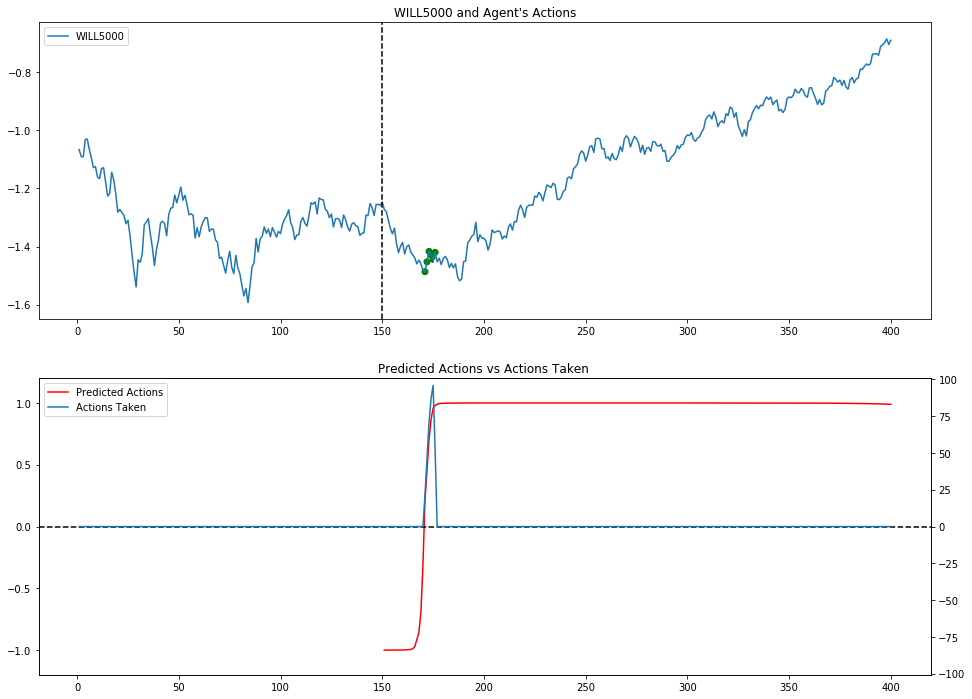

In [12]:
plot_agent_trades(agent, starting = 150, vector_env = True)

For this first episode, the agent waits about 25 steps until it purchases shares. Once it starts, it continues to purchase shares until it has no more cash (the blue line above), but it continues to predict purchases the rest of the episode. The agent was able to beat the market in this episode by waiting until the previous downward trend stabilized and reversed.

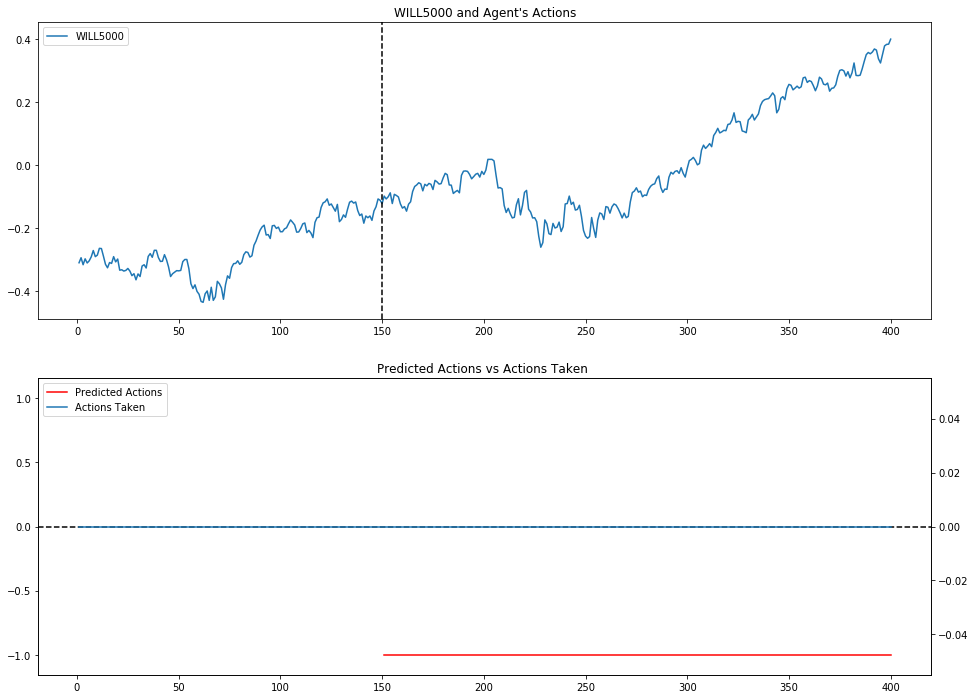

In [13]:
plot_agent_trades(agent, starting = 150, vector_env = True)

In this episode, the agent only predicted sales. Since it has no shares at the beginning, the agent never takes a valid action and has a return of 0%. Clearly, this was not an optimal performance. The agent performs like this in quite a few cases when the market is in an upward trend, so additional training is definitely warranted.

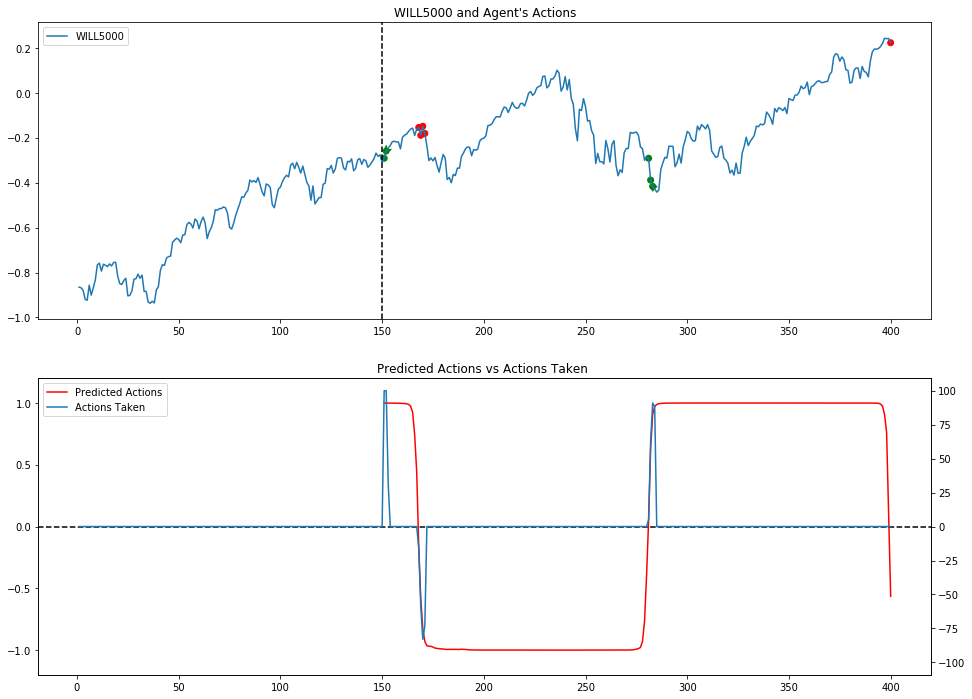

In [15]:
plot_agent_trades(agent, starting = 150, vector_env = True)

Here, the agent does a great job at timing the market, buying low and selling high. The first sale around step 25 is timed almost perfectly, which suggests that there might be some overfitting here. We could probably add more regularization, such as more dropout or a higher beta for the weight decay (L2 regularization), to remedy this.

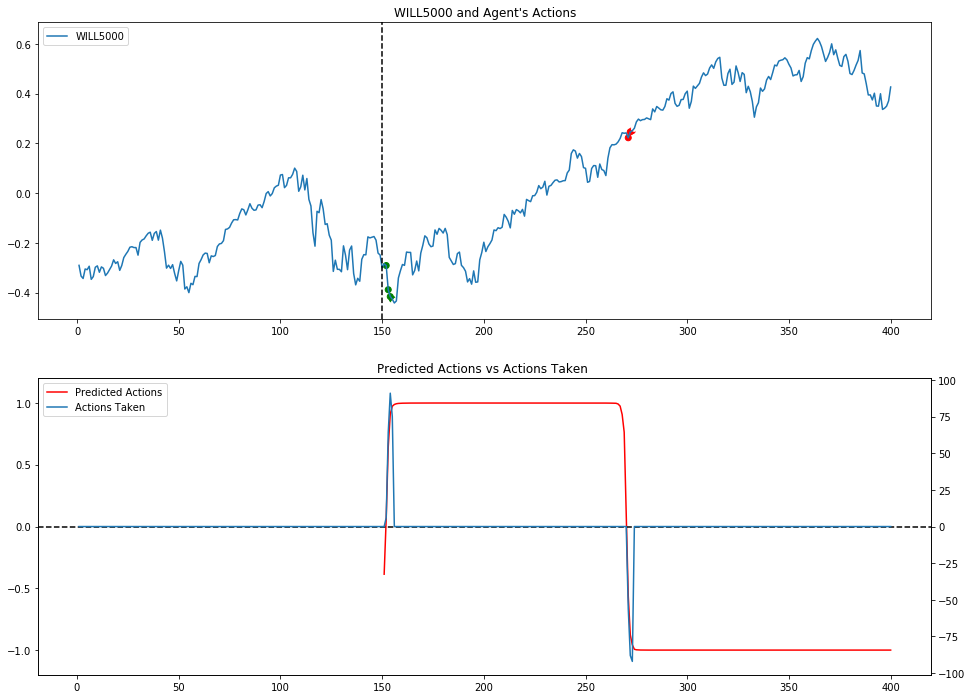

In [18]:
plot_agent_trades(agent, starting = 150, vector_env = True)

Finally, in this episode, the agent buys shares at the beginning and sells them later on, missing out on some future appreciation.

**Conclusion**

The TD3 agent trained above definitely begins to learn to trade the asset. Given the time required and cost of efficient E2C GPU instances, training was limited; significantly more training is likely needed. While additional regularization will probably make training even longer, it could help with generalization as there is some evidence (see above) of overfitting. Looking at various training runs, exploration was a big issue for this problem, and the agent regularly got stuck simply trying to always buy shares or always sell shares (which we can see in one episode above). With more resources and time for hyperparameter tuning, it is very likely that the agent could learn to beat the market the majority of the time and still generalize well.

**Ideas for Future Work**

While a great first step to solving this complex problem, there are a handful of ways we could improve upon the agent trained here:
1. Using a distributional critic that learns the distribution of the state-action function. This can be done in a similar fashion to the C51 and QR-DQN algorithms, which you can read about here: https://arxiv.org/pdf/1707.06887 and https://arxiv.org/pdf/1710.10044.
2. Using non-deterministic agents, such as A2C/A3C. These agents learn the parameterization of an action distribution rather than a deterministic action. These agents explore by sampling the learned distribution rather than adding random noise to a deterministic action. You can read about A3C here: https://arxiv.org/pdf/1602.01783.
3. Using a different exploration strategy. The agent above adds random noise to the deterministic action. Other strategies, such as adding noise to the network parameters, may perform better in this complex environment. One example of this kind of exploration is explored here: https://arxiv.org/pdf/1706.01905.
4. Adding more financial data series to the observation that an agent can use to make decisions. Right now, only macroeconomic data series are included, such as interest rates, index values, etc. Adding company specific information, such as profitability ratios, leverage rations, etc. would definitely produce a more informed agent.
5. Adjusting the trade action mapping so that the agent must only predict valid actions. Because an agent must learn the impact of this kind of mapping on the environment and reward, different mappings may lead to agents learning more quickly.
6. Adjusting the reward function to encourage different behavior. We can adjust the reward function by penalizing no actions to get the agent to trade more. An agent that trades more may explore more, and, therefore, may find better policies as training continues.
7. Using more sophisticated simulation models to produce more training data for the environment. While we tried using simple Geometric Brownian Motion (GBM) to simulate stock prices, GBM is not a good model for many of the other financial times series that a model can use to make informed decision. One idea is to use Generative Adversarial Networks (GANs) to learn the joint distribution for both stock prices and the other financial data and use the GAN to simulate episodes for the environment. GANs have become very popular due to their excellent ability to generate images and music, and we can use these techniques for generating time series data as well. You can read more about GANs in this seminal paper, https://arxiv.org/pdf/1406.2661.pdf, and this paper looks at using GANs specifically for financial time series, https://arxiv.org/pdf/1907.06673.